Usage:
* Choose labels to summarize
* Choose data to load
* Run everything

In [1]:
#%matplotlib notebook

In [2]:
# --- third-party ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tabulate

# --- own ---
from datatools import MeasurementDataReader, MeasurementSeries, Measurement, DataTypes, to_ts_data
from datatools import ACC, GYR, MAG
from fhgutils import contextual_recarray_dtype

In [5]:
# Load all data
mdr = MeasurementDataReader(source="./../data/tool-tracking-data")
data = mdr.query().filter_by(
    MeasurementSeries == ['pythagoras-07-20200724'],  # RIVETER
    DataTypes == [ACC, GYR, MAG]
).get()

Xt, Xc, y = to_ts_data(data, contextual_recarray_dtype)

[INFO] Preparing data from:
  ../data/tool-tracking-data/pneumatic_rivet_gun/pythagoras-07-20200724
  ../data/tool-tracking-data/pneumatic_rivet_gun/pythagoras-07-20200724
  ../data/tool-tracking-data/pneumatic_rivet_gun/pythagoras-07-20200724
  ../data/tool-tracking-data/pneumatic_rivet_gun/pythagoras-07-20200724


[INFO] Read annotation: 100%|██████████| 16/16 [00:00<00:00, 33.38it/s, file=data-02.annotation]

[INFO] Finished with 4 measurement(s).


In [6]:
duration_arr = None
for i in range(0,3):
    # For each measurement, calculate the duration of each window
    data = np.array(Xt[i])
    t_diff = np.diff(data[:, 0])  # conversion from ms to s?
    t_diff = np.insert(t_diff, 0, 0)  # first diff is zero
    yt = np.array(y[i])
    # duration is the summed diffs of timestamps of consecutive, equal y's
    current_y = -1
    duration = 0
    for i in range(len(yt)):
        previous_y = current_y
        current_y = yt[i]
        if current_y == previous_y:
            duration += t_diff[i]
        else:  # add to our duration array
            if duration_arr is None:
                duration_arr = np.array([[current_y, duration]])
            else:
                duration_arr = np.append(duration_arr, np.array([[previous_y, duration]]), axis=0)
            duration = 0
            previous_y = current_y
duration_df = pd.DataFrame(duration_arr, columns=["y", "duration [s]"])

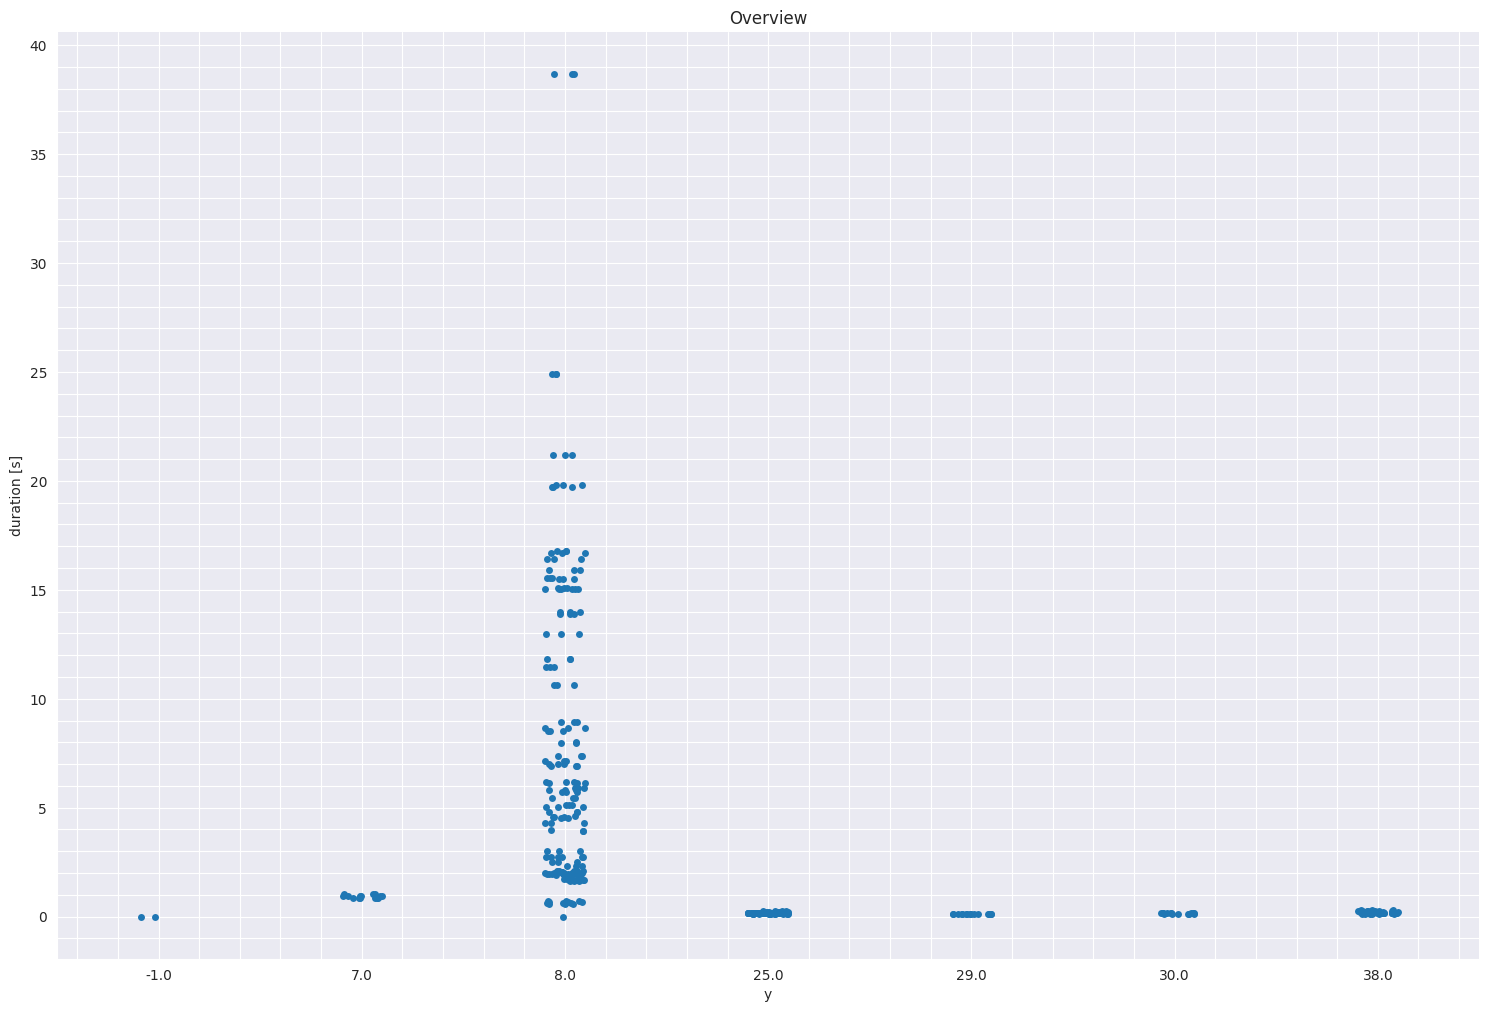

In [7]:
# Categorical scatterplot
g = sns.catplot(x="y", y="duration [s]", data=duration_df, height=10, aspect=1.5)
# Access the underlying axes
ax = g.ax  # Get the single Axes object, as catplot returns a FacetGrid
# Enable minor ticks
ax.minorticks_on()
# Set grid for both major and minor ticks
ax.grid(True, which='both')
# Set the title
ax.set_title("Overview")
plt.show()



Overview:


/tmp/ipykernel_33753/1909563071.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(duration_df_uniq)
/home/shashank/.virtualenvs/tool_tracking_env/lib/python3.13/site-packages/seaborn/distributions.py:2496: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_33753/1909563071.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function 

  Label       Min        Max      Mean    Median         Std    90% Percentile    95% Percentile
-------  --------  ---------  --------  --------  ----------  ----------------  ----------------
     -1  0          0         0         0         0                   0                 0
      7  0.83097    1.03298   0.921683  0.955508  0.0799707           1.02649           1.02844
      8  0         38.6723    8.08164   5.7942    7.2726             16.6691           19.83
     25  0.107537   0.234627  0.157813  0.154947  0.0289681           0.193684          0.232421
     29  0.107537   0.117313  0.113048  0.11621   0.00449732          0.117313          0.117313
     30  0.107537   0.156418  0.136424  0.146642  0.022348            0.156418          0.156418
     38  0.107537   0.316351  0.184932  0.154947  0.0602413           0.263955          0.305791


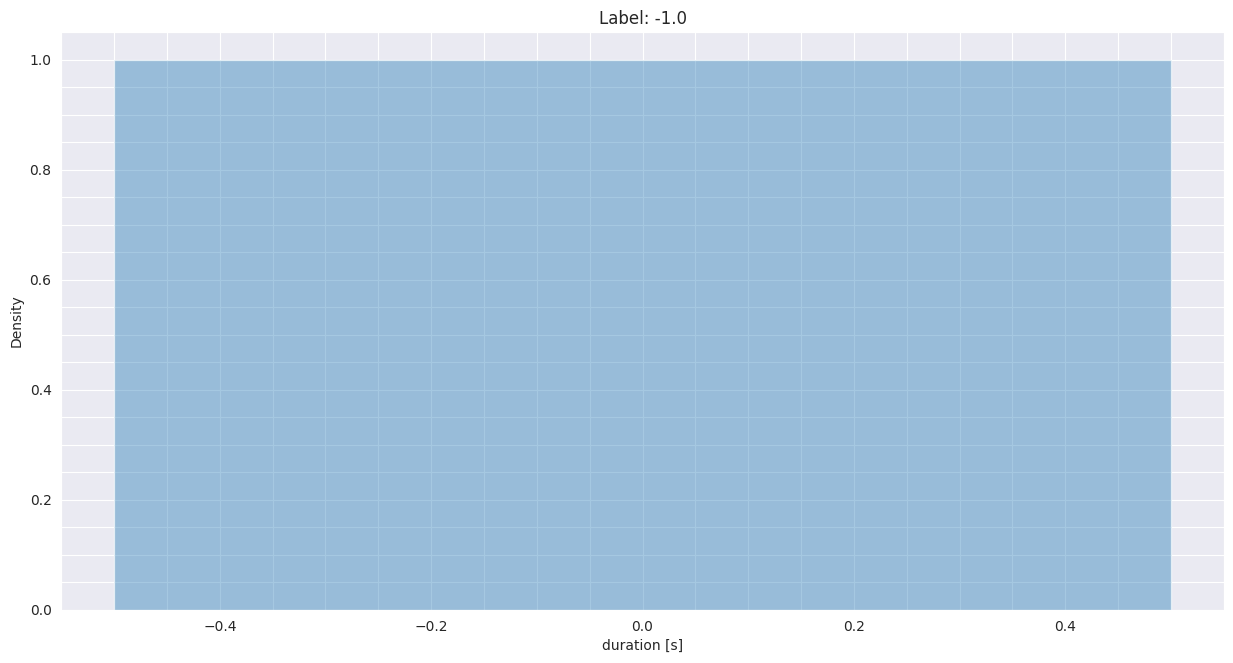

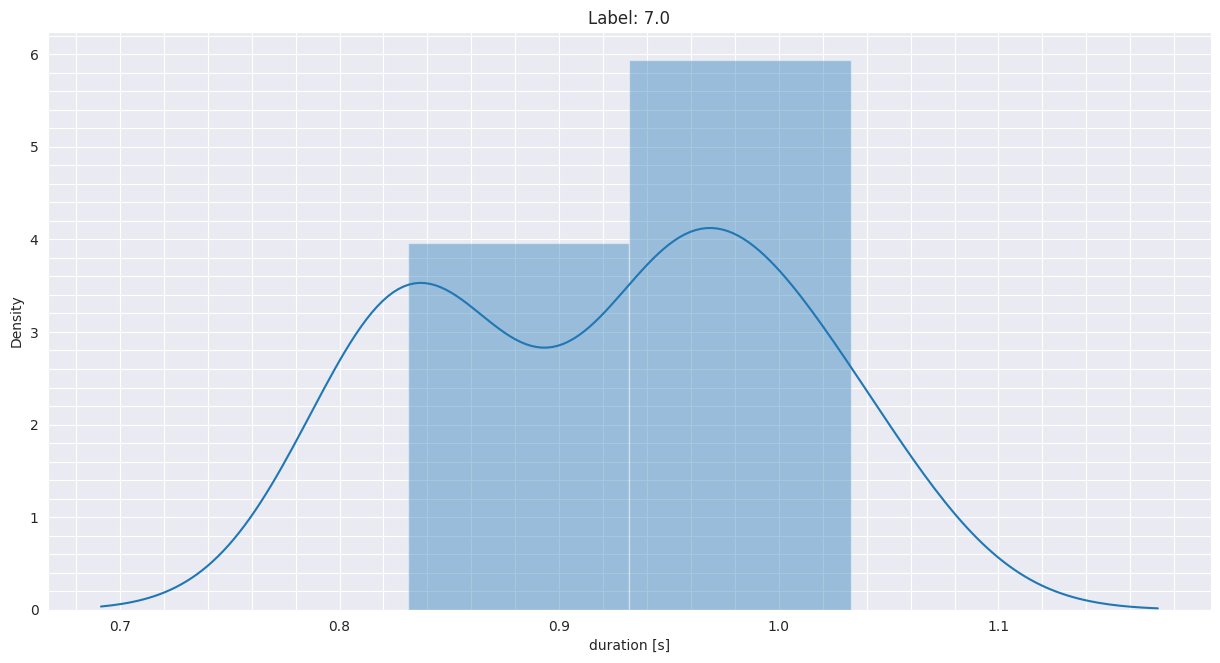

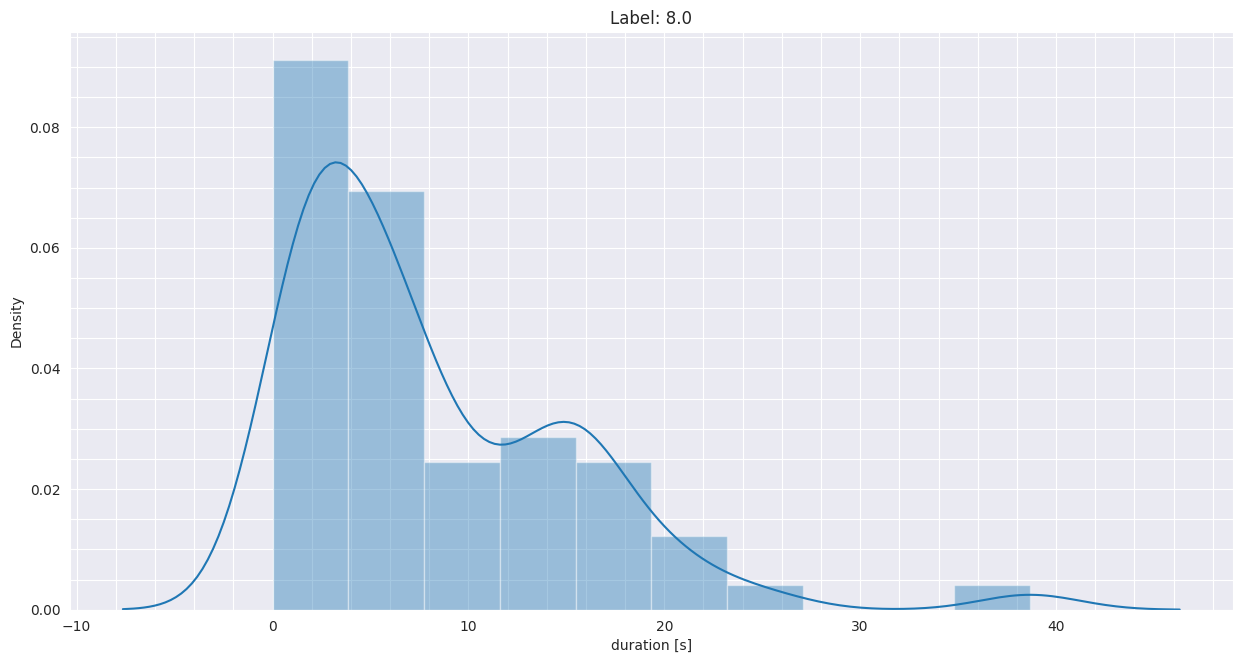

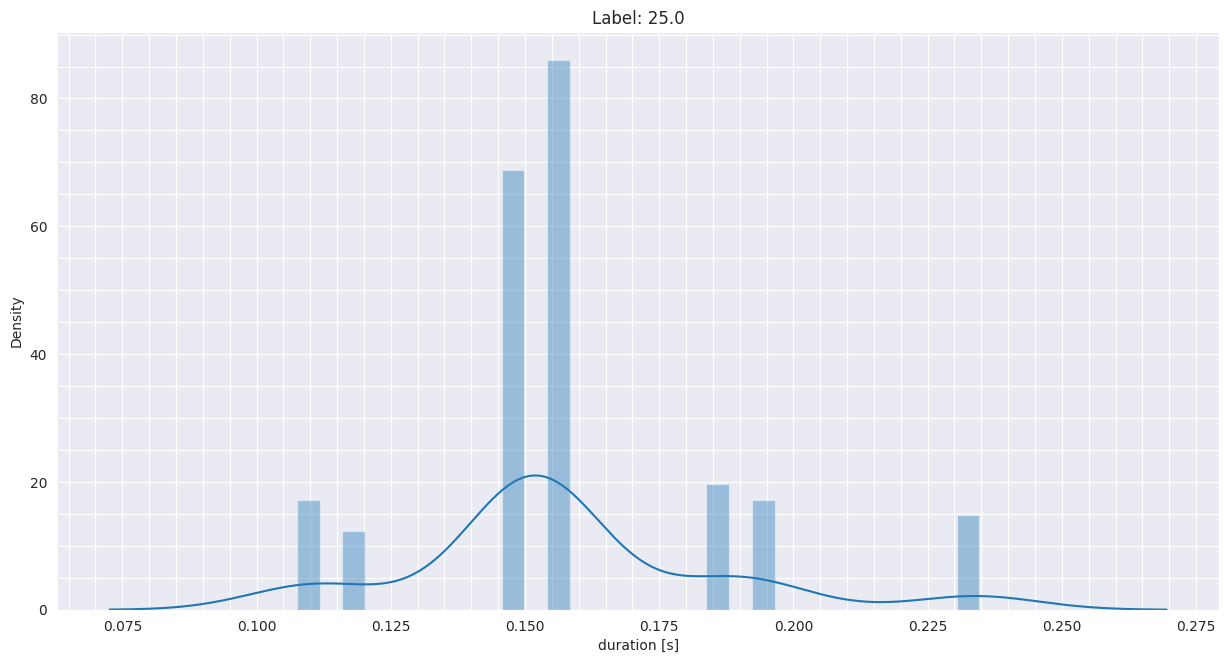

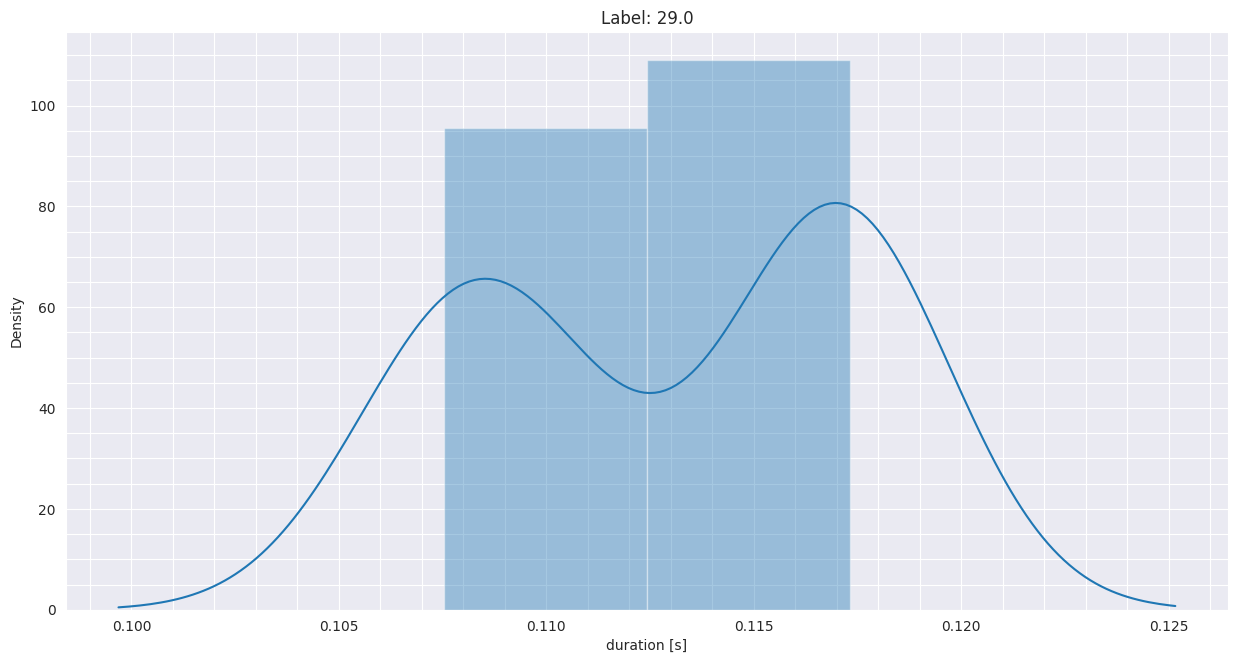

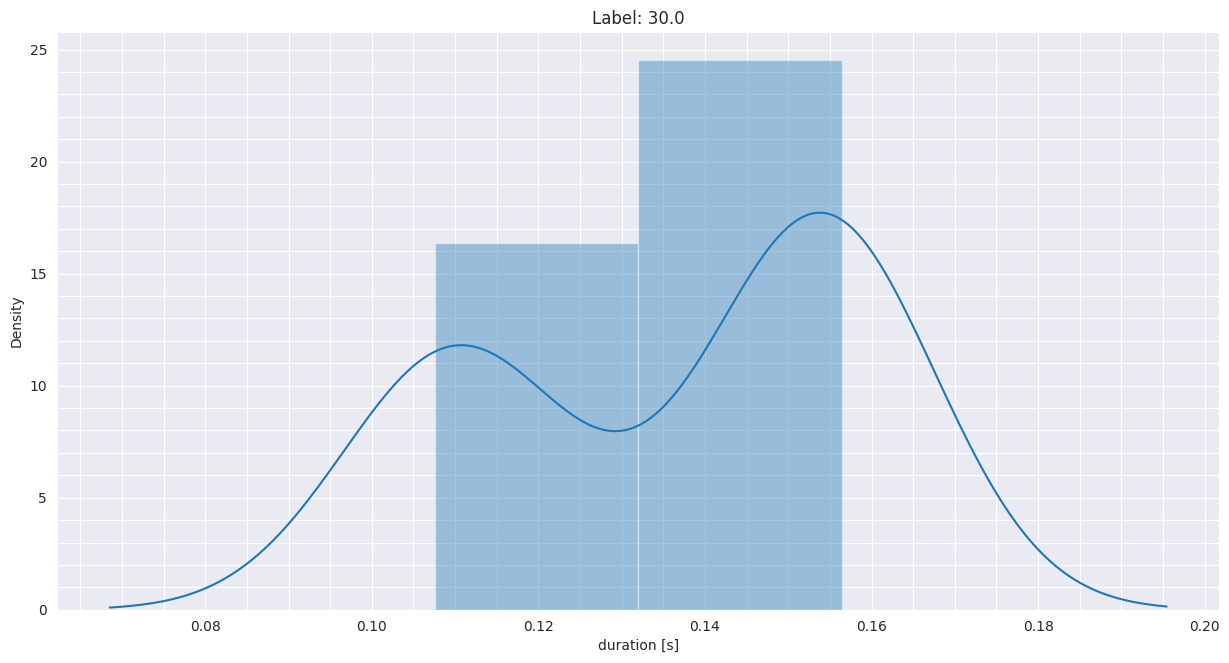

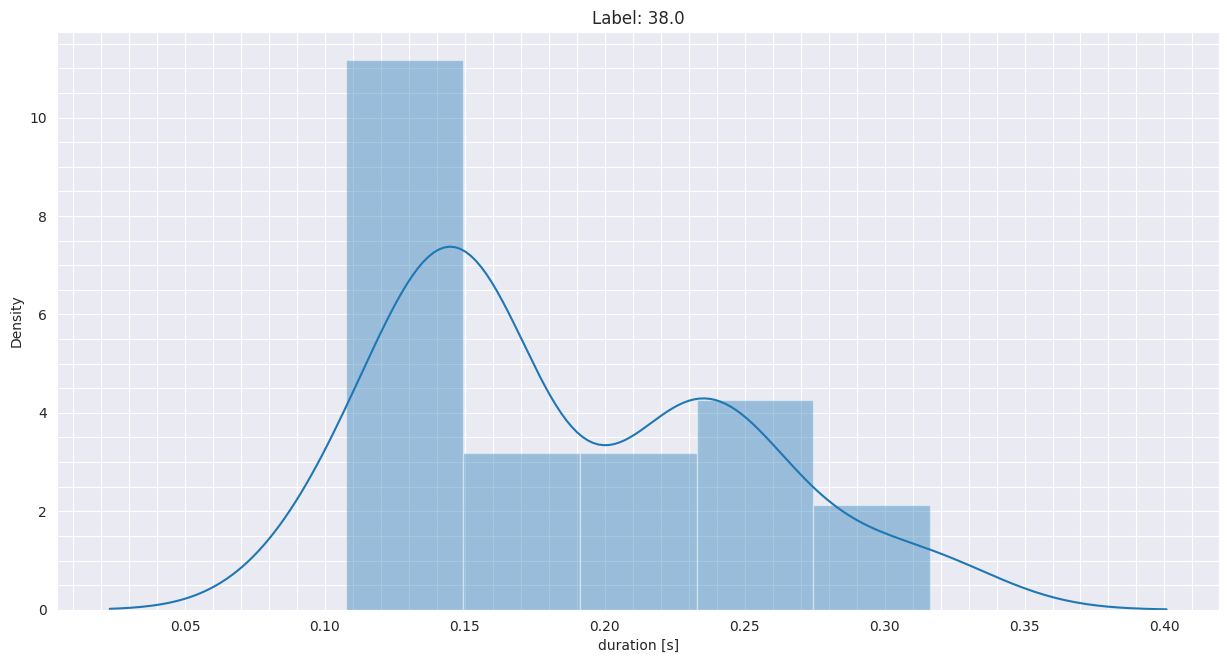

In [8]:
# Detailed single plots
table = []
print("\n\nOverview:")
for y_uniq in np.unique(duration_df.loc[:, "y"]):
    duration_df_uniq = duration_df.loc[duration_df.loc[:, "y"] == y_uniq, "duration [s]"]
    plt.figure(figsize=(15, 7.5))
    sns.distplot(duration_df_uniq)
    plt.title(f"Label: {y_uniq}")
    plt.minorticks_on()
    plt.grid(True, which='both')
    table += [[y_uniq, duration_df_uniq.min(),
               duration_df_uniq.max(),
               duration_df_uniq.mean(),
               duration_df_uniq.median(),
               duration_df_uniq.std(),
               duration_df_uniq.quantile(q=0.9),
               duration_df_uniq.quantile(q=0.95)]]
print(tabulate.tabulate(table, headers=["Label", "Min", "Max", "Mean", "Median", "Std", "90% Percentile", "95% Percentile"]))
plt.show()